In [77]:
import os
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Layer, Bidirectional, Conv2D, Flatten, BatchNormalization, Embedding, Masking
from tensorflow.keras.layers import RepeatVector, concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf

In [78]:
os.chdir('/home/ricky/RNNAE')

data_GP = np.load('data_GP.npy', allow_pickle=True)
data_GP = np.array(data_GP)
data_meta_GP = np.load('data_meta_GP.npy', allow_pickle=True)
data_meta_GP = np.array(data_meta_GP)

print(data_GP.shape)
print(data_meta_GP.shape)


(1144, 7, 185)
(1144, 3)


In [79]:
masking_layer = Masking(mask_value=0., input_shape=(185, 7))
masked = masking_layer(np.asarray(data_GP.transpose((0, 2, 1))).astype('float32'))
print(masked.shape)
print(masked._keras_mask)

(1144, 185, 7)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(1144, 185), dtype=bool)


In [80]:
def create_input(split_portion=0.8, num_of_type=1):

    claimedtype = []

    input = [ [] for i in range(num_of_type+1)]
    input_train = [ [] for i in range(num_of_type+1)]
    input_test = [ [] for i in range(num_of_type+1)]
    type_train = [ [] for i in range(num_of_type+1)]
    type_test = [ [] for i in range(num_of_type+1)]

    for i in range(len(data_meta_GP)):

        if 'Ia' in data_meta_GP[i][-2]:
            claimedtype.append(0)
        if 'IIP' in data_meta_GP[i][-2]:
            claimedtype.append(1)

    for i in range(len(claimedtype)):

        input[0].append(list(data_GP[i]))

        if claimedtype[i] == 0:
            input[1].append(list(data_GP[i]))
        if claimedtype[i] == 1:
            input[2].append(list(data_GP[i]))

    for i in range(len(input)):
        input[i] = np.array(input[i])

        input_train[i] = input[i][:int(split_portion*len(input[i]))]
        input_test[i]  = input[i][int(split_portion*len(input[i])):]

        print(input[i].shape)
        input[i] = input[i].transpose((0, 2, 1))
        '''input_train[i] = input_train[i].transpose((0, 2, 1))
        input_test[i] = input_test[i].transpose((0, 2, 1))'''
        input_train[i] = K.cast_to_floatx(input_train[i].transpose((0, 2, 1)))
        input_test[i] = K.cast_to_floatx(input_test[i].transpose((0, 2, 1)))

        type_train[i] = claimedtype[:int(split_portion*len(input[i]))]
        type_test[i]  = claimedtype[int(split_portion*len(input[i])):]

    for i in range(len(input)-1):
        print(input[i].shape, input_train[i].shape, input_test[i].shape)

    return input, input_train, input_test, type_train, type_test

'''def masking(input_tmp, split): # Poor function definition, input_tmp is problematic, split problem

    weight = []
    input_tmp = input_tmp

    for i in range(input_tmp.shape[0]):
        tmp1 = [1 for j in range(data_GP[i+split][-3])]
        #print(np.array(tmp1).shape)
        tmp2 = [0 for j in range(input_tmp.shape[1] - data_GP[i+split][-3])]
        tmp = np.hstack((tmp1, tmp2))
        weight.append(tmp)

    weight = np.array(weight)
    #print(weight.shape)

    mask = [weight for i in range(input_tmp.shape[2])]
    #print(np.array(mask).shape)
    mask = np.transpose(mask, (1, 2, 0))
    #print(np.array(mask).shape)
    #print(mask)

    return mask'''

'''def masking_2(input_tmp, split):

    return'''

def custom_loss(y_true, y_pred, mask):

    last_band_id = int((data_GP.shape[1] - 3 - 1)/2)+1

    y_true_masked = tf.math.multiply(y_true, mask)
    y_pred_masked = tf.math.multiply(y_pred, mask[:,:,1:last_band_id])
    
    mse = tf.keras.losses.mean_squared_error(y_true = y_true_masked[:,:,1:last_band_id], y_pred = y_pred_masked[:,:,:])

    return mse

def custom_loss2(y_true, y_pred):

    last_band_id = int((data_GP.shape[1] - 3 - 1)/2)+1
    
    mse = tf.keras.losses.mean_squared_error(y_true = y_true[:,:,1:last_band_id], y_pred = y_pred[:,:,:])

    return mse


def rnnae(input):

    input_seq = keras.Input(shape=(input[0].shape[1], input[0].shape[2]))
    input_mask = keras.Input(shape=(input[0].shape[1], input[0].shape[2]))
    #input_conc_phase = keras.Input(shape=(input[0].shape[1], 1))

    x = Masking(mask_value=0., input_shape=(185, 7))(input_seq)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(185, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(50, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    encoded = Bidirectional(GRU(6, activation='tanh', return_sequences=False))(x)

    x = RepeatVector(input[0].shape[1])(encoded)
    #merged = concatenate([x, input_conc_phase], axis=-1)
    #x = BatchNormalization()(merged)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(50, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(185, activation='tanh', return_sequences=True))(x)
    x = BatchNormalization()(x)
    decoded = TimeDistributed(Dense(input[0].shape[2]-3-1))(x)

    #autoencoder = keras.Model([input_seq, input_mask, input_conc_phase], decoded)
    #autoencoder = keras.Model([input_seq, input_mask], decoded)
    autoencoder = keras.Model(input_seq, decoded)
    autoencoder.add_loss(custom_loss2(input_seq, decoded))
    encoder = keras.Model(input_seq, encoded)

    opt = Adam(learning_rate=0.0001)

    autoencoder.compile(optimizer=opt, loss=None)
    #autoencoder.summary()

    return autoencoder, encoder

def rnnae_train(autoencoder, input_tmp):

    callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=50,
                       verbose=0, mode='min', baseline=None,
                       restore_best_weights=True)

    history = autoencoder.fit(x=input_tmp, y=None,
                            validation_split = 0.1,
                            epochs=2,
                            verbose=1,
                            callbacks=[callbacks])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.ylim(0, 0.05)
    plt.show()

    return

def rnnae_test(autoencoder, input_tmp, mask_tmp):

    yhat = autoencoder.predict(x=[input_tmp, mask_tmp], verbose=1)
    yhat_loss = autoencoder.evaluate(x=[input_tmp, mask_tmp], y=None, verbose=1)

    return yhat

def latent_space_demo(encoder, input_tmp):

    latent_space = encoder.predict(input_tmp, verbose=1)

    os.chdir('C:\\Users\\ricky\\FYP\\RNNAE_public\\RNN_latent_space_graph')

    for i in range(latent_space.shape[1] - 1):
        plt.grid()
        plt.scatter(latent_space[:,i], latent_space[:,i+1], s=8)
        plt.savefig(f'id_{i}_vs_id_{i+1}.pdf')
        plt.clf()

    return latent_space

def isolation_forest(latent_space, split):

    clf = IsolationForest(n_estimators=10, warm_start=True)
    clf.fit(latent_space)
    anomaly = clf.score_samples(latent_space)
    anomaly_id = np.argsort(anomaly)

    #os.chdir('/home/ricky/RNNAE/RNN_anomaly_graph')
    #os.chdir(r'C:\Users\ricky\FYP\RNN_anomaly_graph')

    for i, ano in enumerate(anomaly_id):
        #shutil.copy(f'/home/ricky/RNNAE/GP_graph/{data_GP[i+split][-1]}.pdf', f'/home/ricky/RNNAE/RNN_anomaly_graph/')
        shutil.copy(f'C:\\Users\\ricky\\FYP\\RNNAE_public\\GP_graph\\{data_GP[ano+split][-1]}.pdf', f'C:\\Users\\ricky\\FYP\\RNNAE_public\\RNN_anomaly_graph\\{i}_{data_GP[ano+split][-1]}.pdf')

    return anomaly

def reconstruction_graph(input_tmp, yhat, split, filters=['u', 'g', 'i']):

    color1 = ['darkviolet', 'seagreen', 'crimson', 'maroon']
    color2 = ['darkmagenta', 'darkgreen', 'firebrick', 'darkred']

    for i in range(input_tmp.shape[0]):

        os.chdir(r'C:\\Users\\ricky\\FYP\\RNNAE_public\\RNN_reconstruction_graph')

        isExist = os.path.exists(f'.\\{data_GP[i][-1]}')

        if not isExist:
            os.makedirs(f'.\\{data_GP[i][-1]}')
            os.chdir(f'.\\{data_GP[i][-1]}')

        for j, filter in enumerate(filters):
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(1, 1, 1)

            plt.gca().invert_yaxis()

            # And a corresponding grid
            ax.grid(which='major', alpha=0.8)
            ax.grid(which='minor', alpha=0.3)

            plt.xlabel('Timestep', fontsize=15)
            plt.ylabel('Absolute Magnitude', fontsize=15)

            plt.xlim(-50, 185)

            plt.title(f'{data_GP[i+split][-1]}, {data_GP[i+split][-2]}, {filter}')

            #plt.errorbar(data_GP[i+split][0], data_GP[i+split][j+1], y_err=data_GP[i+split][j+4], fmt='v')

            plt.scatter(input_tmp[i,:,0], input_tmp[i,:,j+1], s=2, marker='o', color=color1[j], label='test data'.format('o'))
            plt.scatter(input_tmp[i,:,0], yhat[i,:,j], s=12, marker='X', color=color2[j], label='reconstruction'.format('x'))
            
            plt.legend()

            plt.savefig(f'.\\{data_GP[i][-1]}_{filter}_band.pdf')

            plt.close()

    return

In [81]:
def main():
    input, input_train, input_test, type_train, type_test = create_input()
    '''mask_train = masking(input_train[0], 0)
    mask_test = masking(input_test[0], int(0.8*(data_GP.shape[0])))'''
    autoencoder, encoder = rnnae(input)
    rnnae_train(autoencoder, input_train[0])
    '''yhat = rnnae_test(autoencoder, input_test[0], mask_test)
    latent_space = latent_space_demo(encoder, input_train[0])
    anomaly = isolation_forest(latent_space, 0)
    reconstruction_graph(input_test[0], yhat, int(0.8*(data_GP.shape[0])))'''

(1144, 7, 185)
(1144, 7, 185)
(1144, 185, 7) (915, 185, 7) (229, 185, 7)


2022-02-06 04:21:18.091741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-06 04:21:18.092236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994040000 Hz


Epoch 1/2


2022-02-06 04:21:33.278220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-06 04:21:33.724006: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


26/26 [==============================] - 27s 311ms/step - loss: 1.4091 - val_loss: 0.0295
Epoch 2/2
26/26 [==============================] - 3s 104ms/step - loss: 0.1135 - val_loss: 0.0294


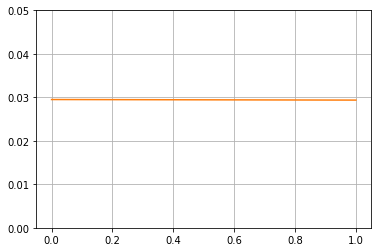

In [82]:
if __name__ == '__main__':
    main()